In [219]:
# !pip install torch
# !pip install pandas
# !pip install scikit-learn


In [220]:
# from google.colab import drive
# drive.mount('/content/drive')

In [221]:
%cd /content/drive/MyDrive/final_exp/code

[Errno 2] No such file or directory: '/content/drive/MyDrive/final_exp/code'
/Users/sheikhjubair/Documents/wheat_large/code


In [222]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import pickle
from scipy.stats import pearsonr
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [223]:
version = 'v1'

In [224]:
geno_training_file = '../processed_data/tr_geno_with_8_m_avg_{}.pkl'.format(version)
pheno_training_file = '../processed_data/tr_pheno_with_8_m_avg_{}.pkl'.format(version)

geno_test_file = '../processed_data/test_geno_with_8_m_avg_{}.pkl'.format(version)
pheno_test_file = '../processed_data/test_pheno_with_8_m_avg_{}.pkl'.format(version)

geno_test_file_unique_env = '../processed_data/test_geno_unique_env_with_8_m_avg_{}.pkl'.format(version)
pheno_test_file_unique_env = '../processed_data/test_pheno_uniqeu_env_with_8_m_avg_{}.pkl'.format(version)

geno_val_file = '../processed_data/val_geno_with_8_m_avg_{}.pkl'.format(version)
pheno_val_file = '../processed_data/val_pheno_with_8_m_avg_{}.pkl'.format(version)

In [225]:
model_path = '../processed_data/fc_model_env_middle_global_local_features_version_{}.pt'.format(version)
pcc_model_path = '../processed_data/fc_model_env_pcc_middle_global_local_features_version_{}.pt'.format(version)
target_scaler_path = '../processed_data/target_scaler_global_local_features_{}.pkl'.format(version)
env_scaler_path = '../processed_data/env_scaler_global_local_features_{}.pkl'.format(version)
training_output_path = '../outputs/env_middle_training_outputs_global_local_features_' + version + '.pkl'
figure_loss_path = '../figures/loss_env_middle_global_local_features_' + version + '.jpeg'
figure_pcc_path = '../figures/pcc_env_moddle_global_local_features_' + version + '.jpeg'
test_output_all_env_path = '../outputs/predicted_all_env_global_local_features_' + version + '.pkl'
test_output_unique_env_path = '../outputs/predicted_unique_env_global_local_features_' + version + '.pkl'

In [226]:
def rescale_data(scaler, predicted):
    rescaled = scaler.inverse_transform(predicted.reshape(-1,1))
    
    return rescaled.reshape(-1,)

In [227]:
### Transformer Model

In [228]:
class FCModel(nn.Module):
    def __init__(self, num_env, num_geno, reduce_dim=2666, output_dim=1):
        super(FCModel, self).__init__()

        self.reduce_dim = reduce_dim
        self.num_geno = num_geno
        self.num_env = num_env

        

        self.fc1 = nn.Linear(num_geno, reduce_dim)
        self.relu1 = nn.ReLU()
        # self.maxpool1 = nn.MaxPool1d(2)
        
        
        self.fc2 = nn.Linear(reduce_dim, reduce_dim)
        self.relu2 = nn.ReLU()
        # self.maxpool2 = nn.MaxPool1d(2)
        
        self.fc3 = nn.Linear(reduce_dim, reduce_dim)
        self.relu3 = nn.ReLU()
        # self.maxpool3 = nn.MaxPool1d(2)

        self.fc4 = nn.Linear(reduce_dim, reduce_dim)
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(reduce_dim, reduce_dim)
        self.relu5 = nn.ReLU()

        self.fc6 = nn.Linear(reduce_dim, reduce_dim)
        self.relu6 = nn.ReLU()

        self.fc7 = nn.Linear(reduce_dim, reduce_dim)
        self.relu7 = nn.ReLU()

        self.fc8 = nn.Linear(reduce_dim, reduce_dim)
        self.relu8 = nn.ReLU()

        self.fc9 = nn.Linear(reduce_dim, reduce_dim)
        self.relu9 = nn.ReLU()

        self.fc10 = nn.Linear(reduce_dim, reduce_dim)
        self.relu10 = nn.ReLU()

        self.fc11 = nn.Linear(reduce_dim, reduce_dim)
        self.relu11 = nn.ReLU()

        self.fc12 = nn.Linear(reduce_dim, reduce_dim)
        self.relu12 = nn.ReLU()
        
        
        self.fc13 = nn.Linear(reduce_dim, reduce_dim)
        self.relu13 = nn.ReLU()
        
        
        self.fc14 = nn.Linear(reduce_dim, reduce_dim)
        self.relu14 = nn.ReLU()
        
        self.fc15 = nn.Linear(reduce_dim, 54)
        self.relu15 = nn.ReLU()
        
        
        self.regress = nn.Linear(54, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        d = x

        x = self.fc2(d)
        x = self.relu2(x)

        x = self.fc3(d)
        x = self.relu3(x)

        x = d + x
        d = x

        x = self.fc4(x)
        x = self.relu4(x)
        
        x = self.fc5(x)
        x = self.relu5(x)

        x = d + x
        d = x
        

        x = self.fc6(x)
        x = self.relu6(x)
        
        x = self.fc7(x)
        x = self.relu7(x)

        x = d + x
        d = x
        
        x = self.fc8(x)
        x = self.relu8(x)

        x = self.fc9(x)
        x = self.relu9(x)

        x = d + x
        d = x
        
        x = self.fc10(x)
        x = self.relu10(x)

        x = self.fc11(x)
        x = self.relu11(x)

        x = d + x
        d = x
        
        x = self.fc12(x)
        x = self.relu12(x)

        x = self.fc13(x)
        x = self.relu13(x)
        
        x = self.fc14(x)
        x = self.relu14(x)
        
        x = d + x
        d = x
        
        x = self.fc15(x)
        x = self.relu15(x)
        
        
       
        x = self.regress(x)
        
        return x

In [229]:
class WheatDataset(Dataset):
    def __init__(self, geno_file, target_file, scaler=None, output_scaler=None):
        self.scaler = scaler
        self.output_scaler=output_scaler
        with open(geno_file, 'rb') as pfile:
            self.data = pickle.load(pfile)

        with open(target_file, 'rb') as pfile:
            self.target = pickle.load(pfile)
        

        ind = self.target <= 10
        self.target = self.target[ind]
        self.data = self.data[ind]
        
        #Remove this line to run with global + local marker set
        # self.data = np.delete(self.data, np.arange(2000, 4052), axis=1)
        
        self.target_original_space = self.target
        self.target_original_space = self.target_original_space.reshape(-1,)

        self.target = self.target.reshape(-1, 1)

        print('number of markers: ', self.data.shape[1])
        print(np.average(self.target))
        print(np.max(self.target))

        if scaler == None:
            self.scaler= MinMaxScaler()
            self.data[:, -81:] = self.scaler.fit_transform(self.data[:, -81:])
        else:
            self.data[:, -81:] = self.scaler.transform(self.data[:, -81:])
            
        if self.output_scaler == None:
            self.output_scaler = MinMaxScaler()
            self.target = self.output_scaler.fit_transform(self.target)
        else:
            self.target = self.output_scaler.transform(self.target)

        self.target = self.target.reshape(-1,)

    def __len__(self):
        return self.data.shape[0]
    
    
    def __getitem__(self, ind):
        return self.data[ind], self.target[ind], self.target_original_space[ind]

In [230]:
def calculate_perf_measure(true, predicted):
    pcc, pval = pearsonr(true, predicted)
    
    return pcc

In [231]:
def pcc_loss(true, predicted):
  x = predicted
  y = true

#   vx = x - torch.mean(x)
#   vy = y - torch.mean(y)

#   cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
  
  x = torch.cat((true, predicted),0)
  cost = torch.corrcoef(x)
  cost = cost[0,1]
  #v2 code added here
  mse_loss = torch.mean((predicted -true)**2)

  total_cost = (1 - cost) + mse_loss

  return total_cost

In [232]:
def train(dataloader, model, criterion, optimizer):
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device("mps")
    model = model.to(device)
    model.train()
    
    tr_running_loss = 0
    predicted = []
    true = []
    count = 0
    for data, target, target_output in dataloader:
        data = data.float()
        data = data.to(device)
        target= target.float()
        target = target.to(device)
        
        
        optimizer.zero_grad()
        
        outputs = model(data)
        outputs= outputs.view(-1,)
        
        loss = criterion(target, outputs)
        loss.backward()
        
        optimizer.step()
        
        tr_running_loss += loss.item()
        
    
        predicted += outputs.detach().cpu().numpy().tolist()
        true += target.detach().cpu().numpy().tolist()

        count+=1

        # print('batch {} completed'.format(count))

    tr_running_loss = tr_running_loss / count    
    predicted = np.array(predicted)
    true = np.array(true)
    
    pcc = calculate_perf_measure(true, predicted)
        
    return tr_running_loss, pcc, model

In [233]:
def evaluate(dataloader, model, criterion):
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device("mps")
    model = model.to(device)
    model.eval()
    
    val_loss = 0
    predicted = []
    true = []
    true_original_space = []
    
    eval_loss = 0
    count = 0
    for data, target, true_scaled in dataloader:
        data = data.float()
        data = data.to(device)
        target= target.float()
        target = target.to(device)
        
        outputs = model(data)
        outputs= outputs.view(-1,)
        
        loss = criterion(target, outputs)
        
        eval_loss += loss.item()
        
        predicted += outputs.detach().cpu().numpy().tolist()
        true += target.detach().cpu().numpy().tolist()
        true_original_space += true_scaled.numpy().tolist()

        count+=1

    eval_loss = eval_loss / count    
    predicted = np.array(predicted)
    true = np.array(true)
    
    pcc = calculate_perf_measure(true, predicted)
    
    return eval_loss, pcc, np.array(true_original_space), predicted

In [234]:
def train_model(tr_dataset, validation_dataset, num_epoch=3000, reduce_dim=256, batch_size=16):
    num_env = 81
    num_geno=tr_dataset.data.shape[1] 
    # num_features = tr_dataset.data.shape[1]
    
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device("mps")
    print('Model is traning on: ', device)
    
    model = FCModel(num_env, num_geno, reduce_dim)
    
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    tr_loader = DataLoader(dataset=tr_dataset, batch_size=batch_size)
    val_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size)
    
    best_val_loss = np.inf
    best_model = None
    best_pcc = np.NINF
    best_pcc_model = None
    no_improve = 0
    i = 0
    best_epoch = 0
    is_loss_improved = False
    is_pcc_improved = False
    
    tr_losses = []
    val_losses = []
    tr_pccs = []
    val_pccs = []
    while True:
        tr_loss, tr_pcc, model = train(tr_loader, model, criterion, optimizer)
        tr_losses.append(tr_loss)
        tr_pccs.append(tr_pcc)
        
        val_loss, val_pcc, true_original_space, predicted = evaluate(val_loader, model, criterion)
        val_losses.append(val_loss)
        val_pccs.append(val_pcc)
        
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     best_model = copy.deepcopy(model)
        #     best_epoch = i
        #     no_improve = 0
        #     is_loss_improved = True
        # else:
        #     is_loss_improved = False
            
        if best_pcc < val_pcc:
            best_pcc_model = copy.deepcopy(model)
            best_model = best_pcc_model
            best_pcc = val_pcc
            is_pcc_improved = True
            best_epoch = i
            no_improve = 0
            is_loss_improved = True
            best_val_loss = val_loss
        else:
            is_pcc_improved = False
            
        if is_pcc_improved == False:
            no_improve += 1
            
        
            
        
            
        print("Current epoch: {} Best epoch {}".format(i, best_epoch))
        print("Training Loss: {}, training PCC: {}".format(tr_loss, tr_pcc))
        print("Validation Loss: {}, validation PCC: {}".format(val_loss, val_pcc))
        print()

        i +=1
        
        if i % 15 == 0:
            print('\nSaving model: ')
            # torch.save(best_pcc_model.state_dict(), '../processed_data/fc_model_env_middle_v2.pt')
            # torch.save(best_pcc_model.state_dict(), '../processed_data/fc_model_env_pcc_middle_v2.pt')
        
        if no_improve == 20:
            break
    best_model=best_pcc_model
    
    return best_model, best_pcc_model, tr_losses, tr_pccs, val_losses, val_pccs

In [235]:
def calculate_pcc_by_env():
  test_data = pd.read_csv()
  test_dataset = WheatDataset(geno_test_file, pheno_test_file) 

In [236]:
print('\nSart reading dataset')
tr_dataset = WheatDataset(geno_training_file, pheno_training_file) 
test_dataset = WheatDataset(geno_test_file, pheno_test_file, tr_dataset.scaler, tr_dataset.output_scaler) 
test_dataset_unique_env = WheatDataset(geno_test_file_unique_env, pheno_test_file_unique_env, tr_dataset.scaler, tr_dataset.output_scaler) 
validation_dataset = WheatDataset(geno_val_file, pheno_val_file, tr_dataset.scaler, tr_dataset.output_scaler) 


Sart reading dataset
number of markers:  4133
4.806148496017522
10.0
number of markers:  4133
4.814702491839821
10.0
number of markers:  4133
4.881761611338767
10.0
number of markers:  4133
4.7388902280622265
10.0


In [237]:
tr_dataset.data.shape

(61514, 4133)

In [238]:
print('\nStarting training: ')
best_model, best_pcc_model, tr_losses, tr_pccs, val_losses, val_pccs = train_model(tr_dataset, validation_dataset, reduce_dim=770, batch_size=64)


Starting training: 
Model is traning on:  mps
Current epoch: 0 Best epoch 0
Training Loss: 0.04745462221304524, training PCC: 0.13216436979089669
Validation Loss: 0.0448839120523778, validation PCC: 0.25297602851079

Current epoch: 1 Best epoch 1
Training Loss: 0.0441859824710725, training PCC: 0.2525628329463806
Validation Loss: 0.04299361874602434, validation PCC: 0.3092164537319433

Current epoch: 2 Best epoch 2
Training Loss: 0.04270034101297943, training PCC: 0.3076362260356045
Validation Loss: 0.042384267423969474, validation PCC: 0.32124033123547935

Current epoch: 3 Best epoch 3
Training Loss: 0.04252895900181915, training PCC: 0.3142693525861354
Validation Loss: 0.04243794671459005, validation PCC: 0.32773036167757974

Current epoch: 4 Best epoch 4
Training Loss: 0.04272744119004685, training PCC: 0.3092327106894832
Validation Loss: 0.042089651182638424, validation PCC: 0.32816017849587126

Current epoch: 5 Best epoch 5
Training Loss: 0.04223294604740061, training PCC: 0.3240

In [239]:
model = best_model
torch.save(model.state_dict(), model_path)

In [240]:
pcc_model = best_pcc_model
torch.save(pcc_model.state_dict(), pcc_model_path)

In [241]:
with open(target_scaler_path, 'wb') as outfile:
    pickle.dump(tr_dataset.output_scaler, outfile)

In [242]:
with open(env_scaler_path, 'wb') as outfile:
    pickle.dump(tr_dataset.scaler, outfile)

In [243]:
df = pd.DataFrame({
    'epochs': list(range(len(tr_losses))) * 2,
    'loss': tr_losses + val_losses,
    'type': ['training'] * len(tr_losses) + ['validation'] * len(val_losses),
    'pcc': np.array(tr_pccs + val_pccs)
})

In [244]:
df.to_pickle(training_output_path)

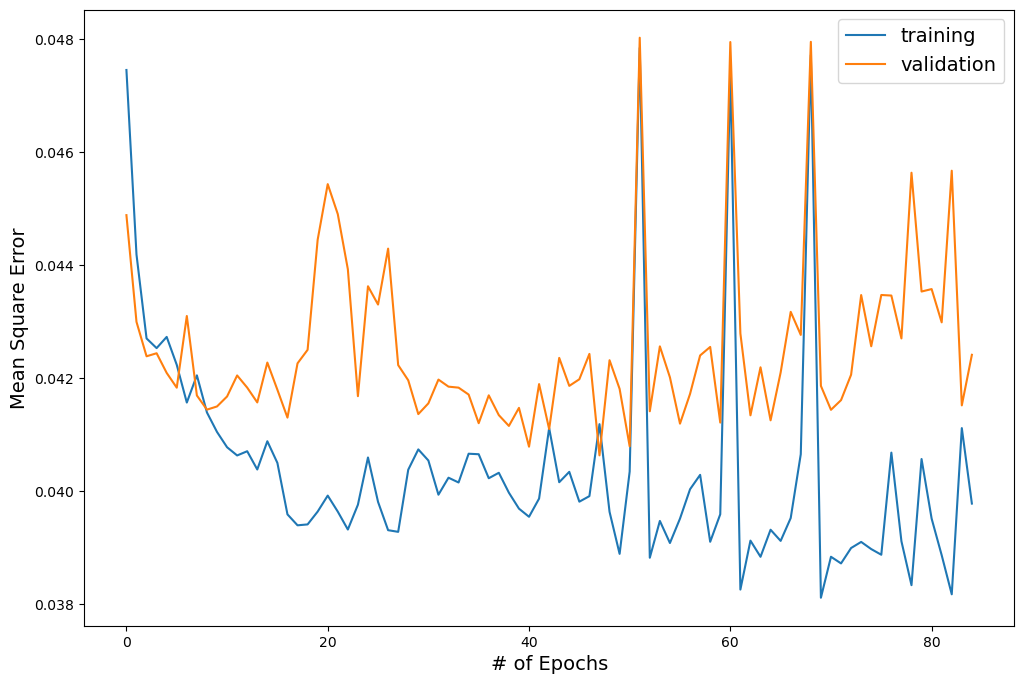

In [245]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
ax = sns.lineplot(data=df, x="epochs", y="loss", hue="type")
ax.set_xlabel("# of Epochs", fontsize = 14)
ax.set_ylabel("Mean Square Error", fontsize = 14)
ax.legend(fontsize=14)
fig = ax.get_figure()
fig.savefig(figure_loss_path, dpi=256 )

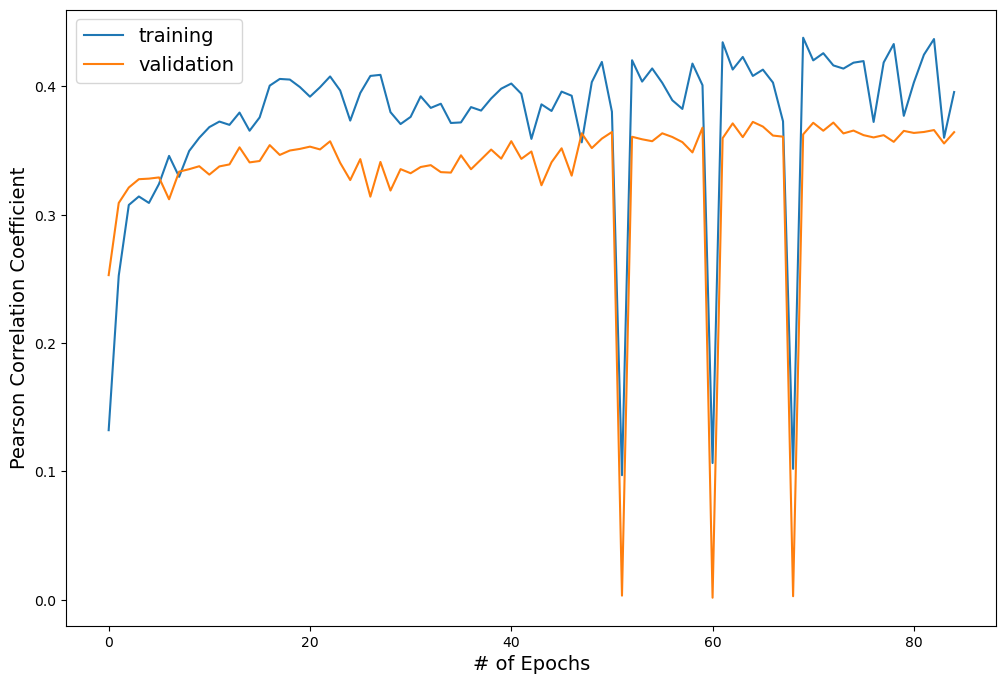

In [246]:
plt.figure(figsize = (12,8))
ax = sns.lineplot(data=df, x="epochs", y="pcc", hue="type")
fig = ax.get_figure()
ax.set_xlabel("# of Epochs", fontsize = 14)
ax.set_ylabel("Pearson Correlation Coefficient", fontsize = 14)
ax.legend(fontsize=14)
fig.savefig(figure_pcc_path, dpi=256)

In [247]:
criterion = nn.MSELoss().to('cuda:0')
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [248]:
test_loss, test_pcc, true_original_space, predicted= evaluate(test_loader, model, criterion)
print('test loss: ', test_loss)
print('test pcc: ', test_pcc)

test loss:  0.041261826098192164
test pcc:  0.3754419478637896


In [249]:
rescaled_predicted = rescale_data(tr_dataset.output_scaler, predicted)
calculate_perf_measure(true_original_space, rescaled_predicted)

0.37544194737487546

In [250]:
df = pd.DataFrame({
    'True': true_original_space,
    'Predicted': rescaled_predicted
})

In [251]:
df.to_pickle(test_output_all_env_path)

In [252]:
# test_loss, test_pcc, true_original_space, predicted = evaluate(test_loader, pcc_model, criterion)
# print('test loss: ', test_loss)
# print('test pcc: ', test_pcc)

In [253]:
criterion = nn.MSELoss().to('cuda:0')
test_loader = DataLoader(dataset=test_dataset_unique_env, batch_size=64, shuffle=False)

In [254]:
test_loss, test_pcc, true_original_space, predicted = evaluate(test_loader, model, criterion)
print('test unique env loss: ', test_loss)
print('test unique env pcc: ', test_pcc)

test unique env loss:  0.04049197226866252
test unique env pcc:  0.2578565917357457


In [255]:
# test_loss, test_pcc, true_original_space, predicted = evaluate(test_loader, pcc_model, criterion)
# print('test unique env loss: ', test_loss)
# print('test unique env pcc: ', test_pcc)

In [256]:
rescaled_predicted = rescale_data(tr_dataset.output_scaler, predicted)

In [257]:
calculate_perf_measure(true_original_space, rescaled_predicted)

0.25785659126565813

In [258]:
df = pd.DataFrame({
    'True': true_original_space,
    'Predicted': rescaled_predicted
})

df.to_pickle(test_output_unique_env_path)